<a href="https://colab.research.google.com/github/aloycwl/ActionWorld/blob/main/Auto_Social_Posting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News API

Fetch news and get a random article to feed into AI

In [ ]:
import requests
import random
import re
from google.colab import userdata

url = f"https://newsapi.org/v2/everything?q=cryptos&sortBy=publishedAt&language=en&apiKey={userdata.get('NEWS')}"

try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()

    articles = data.get('articles', [])

    if articles:
        random_article = random.choice(articles)
        article_info = f"{random_article.get('title', '')}, {random_article.get('description', '')}"

    else:
        article_info = ""

except requests.exceptions.RequestException as e:
    article_info = ""
    print(f"Error fetching data: {e}")

# For debug use
# print(article_info)

# AI API

Send news for processing and generate 3 different json format, image prompt and image itself. If the image credit is used up, copy the prompt to Bing image creator or use Google's Colab Tensor instead.

In [ ]:
from openai import OpenAI
import json
from google.colab import userdata

client = OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1",
  api_key = userdata.get('NVIDIA')
)

combined_prompt = f"""Generate social media posts for Twitter, LinkedIn, and Telegram based on the following article information:

{article_info}

Provide the output in a single JSON object with four keys: 'twitter_post', 'linkedin_post', 'telegram_post', and 'image_prompt'. Each key's value should be the content of the respective social media post or the image generation prompt.

Twitter post should be concise and engaging, suitable for Twitter.
LinkedIn post should be professional and informative, suitable for LinkedIn.
Telegram post should be concise and direct, suitable for Telegram.
Image prompt should be a concise description suitable for generating an image related to the article.
"""

def generate_combined_posts(prompt):
    completion = client.chat.completions.create(
      model="deepseek-ai/deepseek-v3.1-terminus",
      messages=[{"role":"user","content":prompt}],
      temperature=0.2,
      top_p=0.7,
      max_tokens=8192,
      extra_body={"chat_template_kwargs": {"thinking":True}},
    )
    try:
        generated_posts_json = json.loads(completion.choices[0].message.content)
        return generated_posts_json
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON response: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

generated_posts_json = generate_combined_posts(combined_prompt)

# For debug use
# if generated_posts_json:
#     display(generated_posts_json)
# else:
#     print("Failed to generate social media posts.")

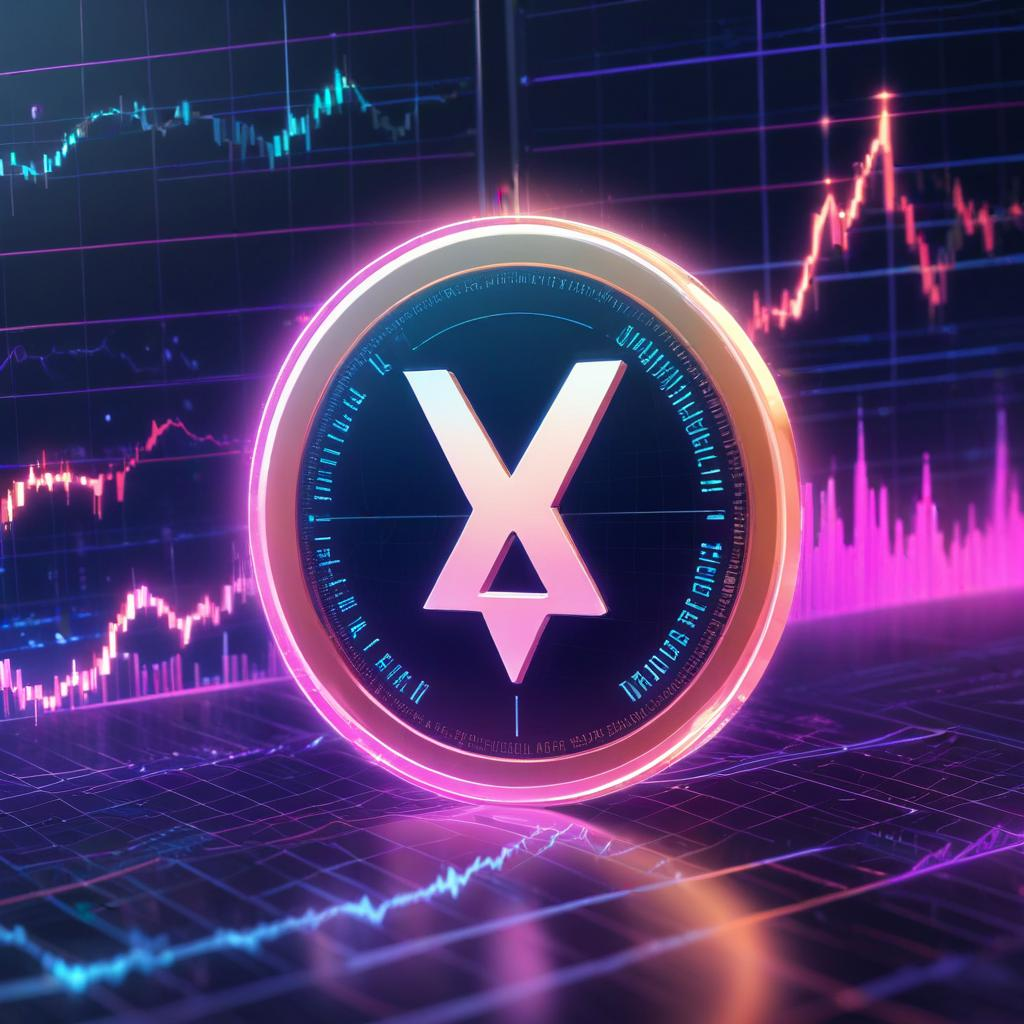

Image saved locally as generated_social_media_image.png


In [ ]:
import requests
import base64
from IPython.display import display, Image
from google.colab import userdata

url = "https://api.freepik.com/v1/ai/text-to-image"

payload = {
    "prompt": generated_posts_json.get('image_prompt', ''),
    "negative_prompt": "b&w, earth, cartoon, ugly",
    "guidance_scale": 2,
    "seed": 42,
    "num_images": 1,
    "image": { "size": "square_1_1" },
    "styling": {
        "style": "anime",
        "effects": {
            "color": "pastel",
            "lightning": "warm",
            "framing": "portrait"
        },
        "colors": [
            {
                "color": "#FF5733",
                "weight": 1
            },
            {
                "color": "#33FF57",
                "weight": 1
            }
        ]
    },
    "filter_nsfw": True
}
headers = {
    "x-freepik-api-key": userdata.get('FREEPIK'),
    "Content-Type": "application/json"
}

image_path = None

try:
    response = requests.post(url, json=payload, headers=headers)
    response.raise_for_status()
    response_body = response.json()

    # Debug use only
    # print(response_body)

    if 'data' in response_body and isinstance(response_body['data'], list) and response_body['data']:
        for item in response_body['data']:
            if 'base64' in item:
                try:
                    img_data = base64.b64decode(item['base64'])
                    display(Image(data=img_data))

                    # Save the image locally
                    image_filename = "generated_social_media_image.png"
                    with open(image_filename, "wb") as f:
                        f.write(img_data)
                    image_path = image_filename # Store the image path
                    print(f"Image saved locally as {image_path}")

                except Exception as e:
                    print(f"Error decoding, displaying, or saving image: {e}")
            else:
                print("No 'base64' key found in image data item.")
    else:
        print("No image data found in the response.")

except requests.exceptions.RequestException as e:
    print(f"Error generating image: {e}")
    if response is not None:
        print(f"Response status code: {response.status_code}")
        print(f"Response body: {response.text}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Social Media API

Send to X / Telegram / LinkedIn

In [ ]:
twitter_post_content = generated_posts_json.get('twitter_post', '')
linkedin_post_content = generated_posts_json.get('linkedin_post', '')
telegram_post_content = generated_posts_json.get('telegram_post', '')

print("Twitter Post Content:")
print(twitter_post_content)
print("\nLinkedIn Post Content:")
print(linkedin_post_content)
print("\nTelegram Post Content:")
print(telegram_post_content)

Twitter Post Content:
Gemini's XRP price prediction: $4.50 in sight after breakout! 🚀 Long-term target: $15. Meanwhile, PEPENODE could be the next 1000x crypto gem. Don't miss out! #XRP #Crypto #PEPENODE #Altcoins

LinkedIn Post Content:
Gemini's recent analysis indicates that XRP could surge to $4.50 following a confirmed breakout from a descending triangle pattern, with a long-term potential of $15 due to a multi-year consolidation. This prediction underscores the dynamic nature of cryptocurrency markets. Additionally, emerging projects like PEPENODE are gaining traction as potential high-growth opportunities. What are your views on these developments? Share your thoughts in the comments. #Cryptocurrency #Investing #XRP #PEPENODE

Telegram Post Content:
🚀 Gemini predicts XRP surge to $4.50 (long-term: $15). PEPENODE tipped as next 1000x crypto. Stay informed for updates!


In [ ]:
twitter_consumer_key = "YOUR_TWITTER_CONSUMER_KEY"
twitter_consumer_secret = "YOUR_TWITTER_CONSUMER_SECRET"
twitter_access_token = "YOUR_TWITTER_ACCESS_TOKEN"
twitter_access_token_secret = "YOUR_TWITTER_ACCESS_TOKEN_SECRET"

telegram_bot_token = "YOUR_TELEGRAM_BOT_TOKEN"

linkedin_access_token = "YOUR_LINKEDIN_ACCESS_TOKEN"

In [ ]:
%pip install tweepy --quiet

In [ ]:
import tweepy

try:
    # Authenticate with Twitter API
    client = tweepy.Client(
        consumer_key=twitter_consumer_key,
        consumer_secret=twitter_consumer_secret,
        access_token=twitter_access_token,
        access_token_secret=twitter_access_token_secret
    )

    # Post the tweet
    response = client.create_tweet(text=twitter_post_content)

    # Print confirmation
    print(f"Tweet posted successfully! Tweet ID: {response.data['id']}")

except Exception as e:
    print(f"Error posting tweet: {e}")


Error posting tweet: 401 Unauthorized
Unauthorized


In [ ]:
try:
    # Define your Telegram bot token and chat ID
    # IMPORTANT: Replace "YOUR_TELEGRAM_BOT_TOKEN" and "YOUR_CHAT_ID" with your actual values
    # You can get your chat_id by messaging your bot and inspecting the updates,
    # for example using getUpdates method: https://api.telegram.org/bot<YOUR_BOT_TOKEN>/getUpdates
    telegram_bot_token = "YOUR_TELEGRAM_BOT_TOKEN"
    chat_id = "YOUR_CHAT_ID"

    # Construct the API endpoint URL
    telegram_api_url = f"https://api.telegram.org/bot{telegram_bot_token}/sendMessage"

    # Prepare the parameters for the API request
    params = {
        'chat_id': chat_id,
        'text': telegram_post_content
    }

    # Make the POST request to the Telegram Bot API
    response = requests.post(telegram_api_url, params=params)

    # Check the response
    if response.status_code == 200:
        print("Telegram message sent successfully!")
    else:
        print(f"Error sending Telegram message. Status code: {response.status_code}")
        print(f"Response body: {response.text}")

except Exception as e:
    print(f"An error occurred while sending Telegram message: {e}")

Error sending Telegram message. Status code: 404
Response body: {"ok":false,"error_code":404,"description":"Not Found"}


In [ ]:
import requests

try:
    # Define your LinkedIn access token
    # IMPORTANT: Replace "YOUR_LINKEDIN_ACCESS_TOKEN" with your actual value
    linkedin_access_token = "YOUR_LINKEDIN_ACCESS_TOKEN"

    # Define the API endpoint URL for posting a share (ugcPosts endpoint)
    # Refer to LinkedIn API documentation: https://learn.microsoft.com/en-us/linkedin/consumer/integrations/self-serve/ugc-post-api
    linkedin_api_url = "https://api.linkedin.com/v2/ugcPosts"

    # Prepare the request payload
    # Refer to LinkedIn API documentation for the required structure
    payload = {
        "author": "urn:linkedin:person:YOUR_LINKEDIN_PERSON_ID", # Replace with your LinkedIn Person URN
        "lifecycleState": "PUBLISHED",
        "specificContent": {
            "com.linkedin.ugc.ShareContent": {
                "shareCommentary": {
                    "text": linkedin_post_content
                },
                "shareMediaCategory": "NONE"
            }
        },
        "visibility": {
            "com.linkedin.ugc.MemberNetworkVisibility": "PUBLIC"
        }
    }

    # Set the necessary headers
    headers = {
        "Authorization": f"Bearer {linkedin_access_token}",
        "Content-Type": "application/json",
        "X-Restli-Protocol-Version": "2.0.0"
    }

    # Make the POST request to the LinkedIn API
    response = requests.post(linkedin_api_url, json=payload, headers=headers)

    # Check the response
    if response.status_code == 201:
        print("LinkedIn post created successfully!")
        print(f"Response body: {response.json()}")
    else:
        print(f"Error creating LinkedIn post. Status code: {response.status_code}")
        print(f"Response body: {response.text}")

except Exception as e:
    print(f"An error occurred while creating LinkedIn post: {e}")

Error creating LinkedIn post. Status code: 401
Response body: {"status":401,"serviceErrorCode":65600,"code":"INVALID_ACCESS_TOKEN","message":"Invalid access token"}
